In [28]:
# some standard packages
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from random import shuffle

# modelling packages
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import model_from_json
# from tensorflow.keras.models import load_model

# Importing tf tools
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix


Utilize the cell below only if using all of the Data Loader file instead of using the Keras Image Generator.

In [2]:
# Open the data files
# X = pickle.load(open('X.pickle', 'rb'))
# y = pickle.load(open('y.pickle', 'rb'))

In [3]:
os.getcwd()

'/home/ec2-user/SageMaker/InvasiveID-Model'

In [4]:
categories = ['class_0', 'class_1', 'class_2', 'class_3']

In [ ]:
# Creating a nested for-loop that will move 20% of the images for each class into a test set
# for each_category in categories: 
    
#     # Make the directory
#     #os.mkdir(path + f'test/{each_category}')
    
#     # Getting a list of the images
#     list_images = [file for file in os.listdir(f'/home/ec2-user/Sagemaker/data/BC-images-clean/{each_category}') if file.endswith('.jpg')]
    
#     # Randomly shuffling the order 
#     shuffle(list_images)
    
#     # Getting the names of the first 20% of images
#     num_test_images = int(len(list_images)*0.2)
#     for_testset = list_images[ : num_test_images]
    
#     # Looping through each image in this list 'for_testset'
#     for each_image in for_testset:
        
#         # Renaming the file path to move those image to test set
#         os.rename(f'/home/ec2-user/Sagemaker/data/BC-images-clean/{each_category}/{each_image}', 
#                   f'/home/ec2-user/Sagemaker/data/BC-images-clean/test/{each_category}/{each_image}')
        
#         # Sanity check
#         print(f'{each_image} moved to "{each_category}" in test.')
    
#     # Another check
#     print(f'{each_category} completed.')

In [5]:
# Use the Keras ImageDataGenerator for memory efficiency and preprocessing ease
# This process replaces the method of obtaining our data via DataLoader.ipynb
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
# train_img_dir = 'Data/train/'
# test_img_dir = 'Data/test/'

In [8]:
batch_size = 32

In [9]:
# # Open the data files
# train = pickle.load(open('train_labels.pickle', 'rb'))
# test = pickle.load(open('test_labels.pickle', 'rb'))

In [10]:
# train.head()

In [11]:
# train['Label'].value_counts()

In [12]:
# train.shape

In [13]:
train_generator = train_datagen.flow_from_directory(
                                                    '/home/ec2-user/SageMaker/data/BC-images-clean/train',
                                                    target_size=(32, 32),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

Found 5387 images belonging to 4 classes.


In [14]:
validation_generator = train_datagen.flow_from_directory(
                                                        '/home/ec2-user/SageMaker/data/BC-images-clean/train/',
                                                        target_size=(32, 32),
                                                        color_mode='rgb',
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        subset='validation'
                                                        )

Found 1344 images belonging to 4 classes.


In [15]:
test_generator = test_datagen.flow_from_directory(
                                                  '/home/ec2-user/SageMaker/data/BC-images-clean/test/',
                                                  target_size=(32, 32),
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1664 images belonging to 4 classes.


In [16]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size 

valid_stepsize = validation_generator.samples//validation_generator.batch_size 

test_stepsize = test_generator.samples//test_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize} \nTest step size = {test_stepsize}')

Training step size = 168 
Validation step size = 42 
Test step size = 52


## VGG-16

In [17]:
# 1.  Import the pretrained VGG16 network, do not include the top layers
pretrained_VGG = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(32, 32, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_VGG.layers:
    layer.trainable=False
    
# Display VGG16 architecture
pretrained_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [18]:

# Instantiate the VGG16 NN model 
weeds_VGG = Sequential()

# Add the pretrained layers 
weeds_VGG.add(pretrained_VGG)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
weeds_VGG.add(Dense(256, activation='relu'))
weeds_VGG.add(Dropout(0.5))
weeds_VGG.add(Dense(512, activation='relu'))

# Adding our activation 
weeds_VGG.add(Dense(4, activation='softmax'))

In [19]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [20]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
weeds_VGG.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
weeds_VGG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 14,979,652
Trainable params: 264,964
Non-trainable params: 14,714,688
_________________________________________________________________


### VGG16 Training

In [21]:
# Fitting the model to the training data
history_VGG = weeds_VGG.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 168 steps, validate for 42 steps
Epoch 1/50
168/168 [==============================] - 24s 142ms/step - loss: 1.1859 - acc: 0.5072 - val_loss: 1.0656 - val_acc: 0.5275
Epoch 2/50
168/168 [==============================] - 23s 136ms/step - loss: 1.0638 - acc: 0.5486 - val_loss: 0.9555 - val_acc: 0.6116
Epoch 3/50
168/168 [==============================] - 23s 136ms/step - loss: 1.0042 - acc: 0.5763 - val_loss: 0.8778 - val_acc: 0.6287
Epoch 4/50
168/168 [==============================] - 23s 137ms/step - loss: 0.9656 - acc: 0.5940 - val_loss: 0.8562 - val_acc: 0.6585
Epoch 5/50
168/168 [==============================] - 23s 136ms/step - loss: 0.9279 - acc: 0.6093 - val_loss: 0.8385 - val_acc: 0.6540
Epoch 6/50
168/168 [==============================] - 23s 137ms/step - loss: 0.9172 - acc: 0.6151 - val_loss: 0.8294 - val_acc: 0.6533
Epoch 7/50
168/168 [=

### VGG16 Results

In [22]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_VGG = weeds_VGG.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_VGG = test_probas_VGG.argmax(axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [23]:
# Getting the true class labels for the test set
test_true_VGG = test_generator.classes

# Sanity check 
test_true_VGG

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [24]:
# Look at what our model predicted
test_predictions_VGG

array([3, 0, 0, ..., 3, 1, 0])

In [25]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_VGG, test_predictions_VGG, target_names=categories))

Classification Report
 
               precision    recall  f1-score   support

     class_0       0.62      0.45      0.52       317
     class_1       0.74      0.62      0.67       258
     class_2       0.71      0.48      0.57       242
     class_3       0.69      0.87      0.77       847

    accuracy                           0.69      1664
   macro avg       0.69      0.60      0.63      1664
weighted avg       0.69      0.69      0.68      1664



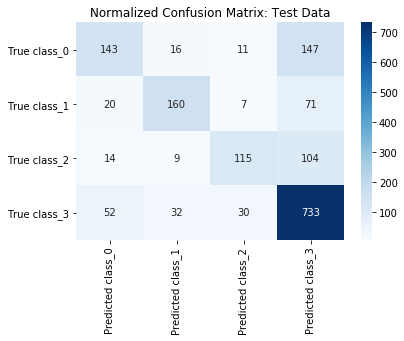

In [26]:
# Get a confusion matrix 
test_matrix_VGG = pd.DataFrame(confusion_matrix(test_true_VGG, test_predictions_VGG), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_VGG, cmap='Blues', annot=True, fmt='g')
plt.title('Normalized Confusion Matrix: Test Data')
plt.show()

## Resnet50  Model

In [29]:
# 1.  Import the pretrained ResNet network, do not include the top layers
pretrained_ResNet = ResNet50(weights='imagenet', include_top=False, pooling='max', classes=4, input_shape=(32, 32, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_ResNet.layers:
    layer.trainable=False
    
# Display ResNet architecture
pretrained_ResNet.summary()

94773248/94765736 [==============================] - 11s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_________________________

In [30]:
# Instantiate the ResNet50 NN model 
weeds_ResNet = Sequential()

# Add the pretrained layers 
weeds_ResNet.add(pretrained_ResNet)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
weeds_ResNet.add(Dense(256, activation='relu'))
weeds_ResNet.add(Dropout(0.5))
weeds_ResNet.add(Dense(512, activation='relu'))

# Adding our activation 
weeds_ResNet.add(Dense(4, activation='softmax'))

In [31]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [32]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
weeds_ResNet.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
weeds_ResNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 24,245,892
Trainable params: 658,180
Non-trainable params: 23,587,712
_________________________________________________________________


### ResNet50 Training

In [34]:
# Fitting the model to the training data
history_ResNet = weeds_ResNet.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 168 steps, validate for 42 steps
Epoch 1/50
168/168 [==============================] - 22s 128ms/step - loss: 0.9861 - acc: 0.5994 - val_loss: 1.2938 - val_acc: 0.5134
Epoch 2/50
168/168 [==============================] - 20s 121ms/step - loss: 0.9693 - acc: 0.6032 - val_loss: 1.3171 - val_acc: 0.5134
Epoch 3/50
168/168 [==============================] - 21s 123ms/step - loss: 0.9581 - acc: 0.6035 - val_loss: 1.3761 - val_acc: 0.5134
Epoch 4/50
168/168 [==============================] - 21s 123ms/step - loss: 0.9563 - acc: 0.6039 - val_loss: 1.3092 - val_acc: 0.5134
Epoch 5/50
168/168 [==============================] - 21s 124ms/step - loss: 0.9408 - acc: 0.6161 - val_loss: 1.3846 - val_acc: 0.5134
Epoch 6/50
168/168 [==============================] - 21s 126ms/step - loss: 0.9405 - acc: 0.6144 - val_loss: 1.4315 - val_acc: 0.5126
Epoch 00006: early stopping


### ResNet50 Results

In [35]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_ResNet = weeds_ResNet.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_ResNet = test_probas_ResNet.argmax(axis=1)

In [38]:
# Getting the true class labels for the test set
test_true_ResNet = test_generator.classes

# Sanity check 
test_true_ResNet

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [39]:
# Look at what our model predicted
test_predictions_ResNet

array([3, 3, 3, ..., 3, 3, 3])

In [40]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_ResNet, test_predictions_ResNet, target_names=categories))

Classification Report
 
               precision    recall  f1-score   support

     class_0       0.00      0.00      0.00       317
     class_1       0.00      0.00      0.00       258
     class_2       0.00      0.00      0.00       242
     class_3       0.51      1.00      0.67       847

    accuracy                           0.51      1664
   macro avg       0.13      0.25      0.17      1664
weighted avg       0.26      0.51      0.34      1664



/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


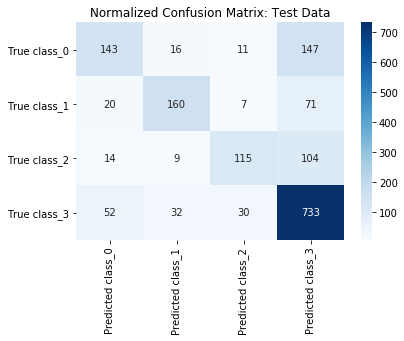

In [26]:
# Get a confusion matrix 
test_matrix_ResNet = pd.DataFrame(confusion_matrix(test_true_ResNet, test_predictions_ResNet), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_ResNet, cmap='Blues', annot=True, fmt='g')
plt.title('Normalized Confusion Matrix: Test Data')
plt.show()

## Xception Model

In [45]:
# 1.  Import the pretrained Xception network, do not include the top layers
pretrained_Xception = Xception(weights='imagenet', include_top=False, pooling='max', classes=4, input_shape=(71, 71, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_Xception.layers:
    layer.trainable=False
    
# Display Xception architecture
pretrained_Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Insert our layers into the Xception model

In [46]:
# Instantiate the ResNet50 NN model 
weeds_Xception = Sequential()

# Add the pretrained layers 
weeds_Xception.add(pretrained_Xception)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
weeds_Xception.add(Dense(256, activation='relu'))
weeds_Xception.add(Dropout(0.5))
weeds_Xception.add(Dense(512, activation='relu'))

# Adding our activation 
weeds_Xception.add(Dense(4, activation='softmax'))

In [47]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [48]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
weeds_Xception.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
weeds_Xception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 2052      
Total params: 21,519,660
Trainable params: 658,180
Non-trainable params: 20,861,480
_________________________________________________________________


### Xception Training

In [49]:
# Fitting the model to the training data
history_Xception = weeds_Xception.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 168 steps, validate for 42 steps
Epoch 1/50
168/168 [==============================] - 24s 145ms/step - loss: 1.3200 - acc: 0.5038 - val_loss: 1.2907 - val_acc: 0.5134
Epoch 2/50
168/168 [==============================] - 20s 119ms/step - loss: 1.2461 - acc: 0.5145 - val_loss: 1.2331 - val_acc: 0.5134
Epoch 3/50
168/168 [==============================] - 20s 118ms/step - loss: 1.2238 - acc: 0.5128 - val_loss: 1.2283 - val_acc: 0.5134
Epoch 4/50
168/168 [==============================] - 20s 119ms/step - loss: 1.2270 - acc: 0.5119 - val_loss: 1.2256 - val_acc: 0.5134
Epoch 5/50
168/168 [==============================] - 20s 121ms/step - loss: 1.2191 - acc: 0.5132 - val_loss: 1.2283 - val_acc: 0.5134
Epoch 6/50
168/168 [==============================] - 20s 119ms/step - loss: 1.2201 - acc: 0.5122 - val_loss: 1.2276 - val_acc: 0.5134
Epoch 00006: early stopping


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y) 

In [ ]:
# # Building the Model
# model = Sequential()

# # # 3 convolutional layers
# model.add(Conv2D(28, (3,3), input_shape = (28,28,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# # # 2 hidden layers
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))

# model.add(Dense(128))
# model.add(Activation('relu'))

# # # The output layer with 9 neurons for 9 classes
# model.add(Dense(9))
# model.add(Activation('softmax'))

# # # Compiling the model using some basic parameters
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [ ]:
train_generator.filenames

In [ ]:
# # Train the model
# history = model.fit_generator(generator=train_generator,
#                     steps_per_epoch=(11209) // batch_size,
#                     epochs=50, 
#                     validation_data=validation_generator,
#                     validation_steps=(2798) // batch_size,
#                     callbacks=[
#                         EarlyStopping(patience=3, restore_best_weights=True),
#                         ReduceLROnPlateau(patience=2)],
#                     verbose=1)